## Analyze sampled Reddit comments: 

## Inter-subreddit analysis of positive and negative voted comments


### The question:



### References:

- [Overview of Text Similarity Metrics in Python](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)

- [The Current Best of Universal Word Embeddings and Sentence Embeddings](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)

- [Machine Learning :: Cosine Similarity for Vector Space Models (Part III)](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/)

- [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)




In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv
import glob

# read all labelled files in this folder 
srcdir = './data_labeled/'

sub2use = ['aww', 'funny', 'todayilearned','askreddit',
           'photography', 'gaming', 'videos', 'science',
           'politics', 'politicaldiscussion',             
           'conservative', 'the_Donald']

# flag subs as political or not
political = [False,False,False,False,False,False,False,False,
            True,True,True,True]

# load all labelled CSVs
dfs = []
for subname in sub2use:
    pathname = srcdir+'comment_sample_'+subname+'_labeled.csv'
#     print('reading',pathname)
    tdf = pd.read_csv(pathname)
    dfs.append(tdf)

# concat all subreddit datasets into one  
df = pd.concat(dfs).drop_duplicates()

# remove any deleted or removed comments 
df = df[(df.text!='[deleted]') & (df.text!='[removed]')]

# drop samples with NaNs
df.dropna(inplace=True)

print('\ntotal comment samples read:',df.shape[0])



total comment samples read: 3261978


## Select most positive and negative scored comments

Split dataset into positive and negative scored comments. Positively scored comments are "liked" by other users, while negatively scored comments are "disliked".

Scores for all subreddits are ranged between -5 and +5


In [3]:
# threshold for selecting positive and nagative scored comments
score_thresh = 2

df_hi = df[df.pca_score > score_thresh]
df_lo = df[df.pca_score < -score_thresh]

print('df_hi.shape',df_hi.shape,'df_lo.shape',df_lo.shape)

df_hi.shape (143974, 20) df_lo.shape (38819, 20)


## subsample comments

Balance samples so that there are equal numbers for all subreddits

In [4]:
def subsample_comments(df, samplesize=None, minchars=0, verbose=False):
    """Randomly subsample text in a df so that all categories 
      (in column 'sub_name') have equal numbers of samples
    """
    subnames = df.sub_name.unique()
    dfs = []
    print()
    for subname in subnames:
        tdf = df[(df['sub_name']==subname) & 
                 (df['text'].str.len()>=minchars)]
        if tdf.shape[0] < samplesize:
            print('warning: only %5d samples in category %s'%(
                tdf.shape[0],subname))
        elif verbose:
            print('%5d samples in category %s'%(
                tdf.shape[0],subname))
        dfs.append( tdf.sample(min(tdf.shape[0],samplesize)) )
    return pd.concat(dfs)
  

numsamples = 1000 # number of samples to take from each subreddit
minchars = 10 # threshold for rejecting too-short comments

dfss_hi = subsample_comments(df_hi, samplesize=numsamples, 
                             minchars=minchars, verbose=False)
dfss_lo = subsample_comments(df_lo, samplesize=numsamples, 
                             minchars=minchars, verbose=False)

print('\nafter subsampling: dfss_hi.shape',dfss_hi.shape,
      'dfss_lo.shape',dfss_lo.shape)




after subsampling: dfss_hi.shape (12000, 20) dfss_lo.shape (12000, 20)


## Prepare the text for analysis and vectorization

Clean up the text by 
- Removing non-alphanumeric characters
- Remove stop words
- Making lowercase
- Stemming

In [5]:
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as sw

def process_comment_text(comments, stemmer=None, 
                         regexstr=None, lowercase=True,
                         removestop=False):
    """Process a list of comment text by optionally:
              stemming, 
              applying a regex expression,
              converting to lowercase,
              removing stop words
    """
    
    if type(stemmer) == str:
        if stemmer.lower() == 'porter':
            stemmer = PorterStemmer()
        elif stemmer.lower() == 'snowball':
            stemmer = SnowballStemmer(language='english')
        else:
            stemmer = None
            
    processed = comments
    
    # make text lowercase
    if lowercase == True:
        print('make text lowercase')
        processed = processed.str.lower()
        
    # remove stop words
    # NOTE: stop words w/ capitals not removed!
    if removestop == True:
        print('remove stop words')
        stopwords = sw.words("english")
        processed = processed.map(lambda text: ' '.join([word for word in text.split() if word not in stopwords]))
        
    # apply regex expression
    if regexstr is not None:
        print('apply regex expression')
        regex = re.compile(regexstr) 
        processed = processed.str.replace(regex,' ')
        
    # stemming
    # NOTE: stemming makes all lowercase
    if stemmer is not None:
        print('stemming')
        processed = processed.map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
        
    print('done')
        
    return processed

# set up text pre-processing arguments
#  NOTE: normally I'd stem in an NLP task but here I want 
#        whole words for the wordcloud figures below.
processkwargs = {
    'stemmer': None,
    'regexstr':"[^a-zA-Z0-9'\s]", # drop non-alphanumeric, spaces or '
    'lowercase':True,
    'removestop':False
                }

# clean up the selected high and low scored comment text,
dfss_hi['text_cl'] = process_comment_text(dfss_hi['text'], **processkwargs)
dfss_lo['text_cl'] = process_comment_text(dfss_lo['text'], **processkwargs)


make text lowercase
apply regex expression
done
make text lowercase
apply regex expression
done


## combine all text within each subreddit


In [6]:
def combine_text_by_category(df,catcol,textcol,catlist):
    """Combine text in a df col into one string, 
      separate by a given category col. 
    """
    cats = df[catcol].unique()
    textlist = []
    for cat in catlist:
        textlist.append(df[df[catcol]==cat][textcol].str.cat(sep=' '))
    return textlist
    
text_concat_hi = (
    combine_text_by_category(dfss_hi,'sub_name', 'text_cl', sub2use) )
                        
text_concat_lo = (
    combine_text_by_category(dfss_lo,'sub_name', 'text_cl', sub2use) )

# print resulting text sizes by subreddit
if False:
    print('positive comment total char count:')
    for i,subname in enumerate(sub2use):
        print(subname,len(text_concat_hi[i]))

    print('\nnegative comment total char count:')
    for i,subname in enumerate(sub2use):
        print(subname,len(text_concat_lo[i]))
    

## Vectorize the text

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define model defaults for TF-IDF vectorizer.
tfidfargs = {
    "analyzer":'word', 
    "max_features" : None,
    "max_df" : 0.5, # Filters out terms that occur in >= n% docs
    "min_df" : 5, # Filters out terms that occur in <= n documents.
    "ngram_range":(1, 1), # unigrams
    "stop_words" : None,   #None, #"english", # Strips out “stop words”
    "use_idf" : True
    }

# create the vectorizer 
vectorizer = TfidfVectorizer(**tfidfargs)

# Transform the comment text into vectorized data.
X_hi = vectorizer.fit_transform(text_concat_hi)
X_lo = vectorizer.fit_transform(text_concat_lo)

print('X_hi.shape',X_hi.shape, 'X_lo.shape',X_lo.shape)

X_hi.shape (12, 1677) X_lo.shape (12, 1400)


## Calculate cosine similarity

Apply cosine similarity to the word vectors created by TfidfVectorizer.

The result will be a square confusion matrix.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate pairwise similarities
cossim_hi = cosine_similarity(X_hi)
cossim_lo = cosine_similarity(X_lo)

# convert to pandas dataframes
df_mx_hi_2 = pd.DataFrame(cossim_hi,
                             index=sub2use, 
                             columns=sub2use)
df_mx_lo_2 = pd.DataFrame(cossim_lo,
                             index=sub2use, 
                             columns=sub2use)

## Plot similarity matrices

How similar are the word vectors between subreddits for positive and negatively scored comments?

I've ordered the subreddits by whether they are non-political (the first 8 categories) or political (the last 4 categories). If there are differences between political vs non-political, then you should see a pattern of darker (more correlated) blocks on the diagonal surrounded by lighter blocks. And, that's exactly what you see here.


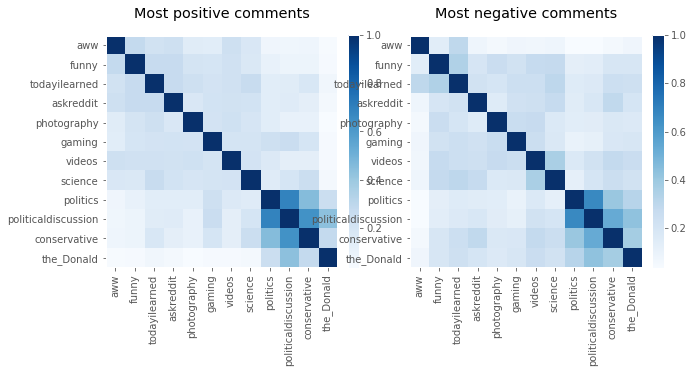

In [9]:
def plot_similarity_mx_df(similarity_mx, title=''):
    ax = plt.gca()
    cax = ax.matshow(similarity_mx, cmap=plt.cm.Blues)
    plt.gcf().colorbar(cax,fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(similarity_mx.columns)))
    ax.set_yticks(range(len(similarity_mx.columns)))
    ax.set_xticklabels(similarity_mx.columns, rotation = 90)
    ax.set_yticklabels(similarity_mx.columns)
    ax.xaxis.set_ticks_position('bottom')
    ax.grid(False)
    plt.title(title)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_similarity_mx_df(df_mx_hi_2, title='Most positive comments')   
    
plt.subplot(1,2,2)
# plt.figure(figsize=(5,5))
plot_similarity_mx_df(df_mx_lo_2, title='Most negative comments')   
 

## Map sub comment text similarities using Multi-Dimensional Scaling

Next, I take the reciprocal of the cosine similarity matrices to create a dis-similarity (or distance) matrix, then use Multi-Dimensional Scaling to map how close each subreddit is to the others.

Note that the MDS algorithm will randomly rotate and/or invert the mapping space each time it is run. That means you have to look at the relationship between points in the map, not their absolute locations.

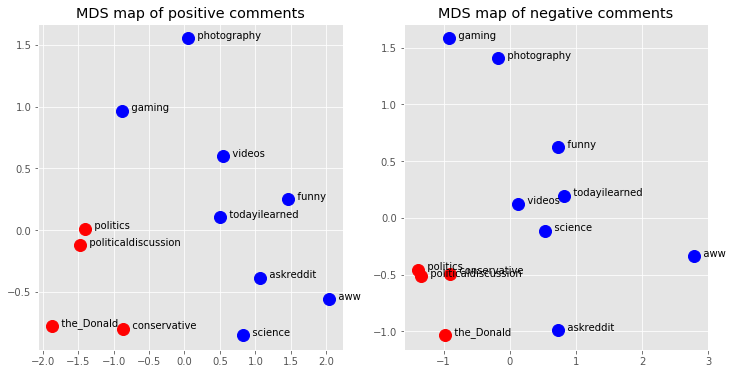

In [10]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_MDS_mapping(similarity_mx, labels, ndims=2, title='', 
                     politics_flag=None):
    """Given a similarity matrix, calculate the MDS coordinates
            and then plot them on a map. 
       Plot political subs in red, non-political in blue.
       """
    
    mds = MDS(n_components=ndims, n_init=100, metric=False, 
              max_iter=1000,eps=.00001,dissimilarity='precomputed' )
    coords = mds.fit_transform(1-similarity_mx)
    coords = StandardScaler().fit_transform(coords)
    coords = PCA(n_components=ndims).fit_transform(coords)

    labels = ['   '+s for s in labels]

    plt.title(title)

    plt.plot(coords[politics_flag,0], coords[politics_flag,1],'ro', markersize=12)
    for x, y, subname in zip(coords[politics_flag,0], coords[politics_flag,1], 
                             np.array(labels)[politics_flag]):    
        plt.text(x, y, subname)

    plt.plot(coords[~np.array(politics_flag),0], coords[~np.array(politics_flag),1],
             'bo', markersize=12)
    for x, y, subname in zip(coords[~np.array(politics_flag),0], coords[~np.array(politics_flag),1], 
                             np.array(labels)[~np.array(politics_flag)]):    
        plt.text(x, y, subname)

        
# plot positive and negative comment data in separate figures        
fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plot_MDS_mapping(df_mx_hi_2, sub2use, ndims=2, 
                 title='MDS map of positive comments', 
                 politics_flag=political)

plt.subplot(1,2,2)
plot_MDS_mapping(df_mx_lo_2, sub2use, ndims=2, 
                 title='MDS map of negative comments', 
                 politics_flag=political)


## Political vs non-political wordclouds

I want to actually look at the words that are most commonly used in each of the categories of text I've created: positive vs negative, political vs non-political. Are there words that stand out as being predictive of a down or up voted comment, or political vs non-political? For this analysis, I'll use a wordcloud.



### Combine all text for each category

To prepare the text for the wordcloud analysis, I need to combine all text for each of the categories:

In [11]:
# concat high rated political comments 
wordstr_politics_hi = ' '.join(text_concat_hi[8:])
# concat low rated political comments 
wordstr_politics_lo = ' '.join(text_concat_lo[8:])

# concat high rated non-political comments 
wordstr_nonpolitics_hi = ' '.join(text_concat_hi[:8])
# concat low rated non-political comments 
wordstr_nonpolitics_lo = ' '.join(text_concat_lo[:8])


### Remove words that are common to all categories

Wordclouds are susceptible to common and uninteresting words (such as stop words) showing up as most frequent (i.e. bigger font size) and obscuring the interesting words. Here, I remove the common words to all datasets so the unique words to each category can pop out.

In [12]:
from collections import Counter, OrderedDict

def text_to_wordlist(text):
    """Create wordlist from text str, strip whitespace"""
    return [s.strip() for s in text.replace('\n',' ').split(' ')]
    
def list_words_by_most_common(wordlist):
    """Given list of words from a text, returns list of all words, 
        sorted by most repeated with duplicated removed
    """
    # sort by most common, drop duplicates, return list
    return list(OrderedDict.fromkeys(
        sorted(wordlist, key=Counter(wordlist).get, reverse=True)))

wordcount = 500 # number of most common words to remove 

# convert text strings into lists of words
wordlist_politics_hi = text_to_wordlist(wordstr_politics_hi)
wordlist_politics_lo = text_to_wordlist(wordstr_politics_lo)
wordlist_nonpolitics_hi = text_to_wordlist(wordstr_nonpolitics_hi)
wordlist_nonpolitics_lo = text_to_wordlist(wordstr_nonpolitics_lo)

# get a list of words common to all categories
common_to_all = ( 
    set(list_words_by_most_common(wordlist_politics_hi)[:wordcount]) &
    set(list_words_by_most_common(wordlist_politics_lo)[:wordcount]) &
    set(list_words_by_most_common(wordlist_nonpolitics_hi)[:wordcount]) &
    set(list_words_by_most_common(wordlist_nonpolitics_lo)[:wordcount]) 
    )

# reform text after dropping words common to all categories
wordstr_politics_hi2 = ' '.join([w for w in wordlist_politics_hi if w not in common_to_all])
wordstr_politics_lo2 = ' '.join([w for w in wordlist_politics_lo if w not in common_to_all])
wordstr_nonpolitics_hi2 = ' '.join([w for w in wordlist_nonpolitics_hi if w not in common_to_all])
wordstr_nonpolitics_lo2 = ' '.join([w for w in wordlist_nonpolitics_lo if w not in common_to_all])


## plot word clouds of each category of comment


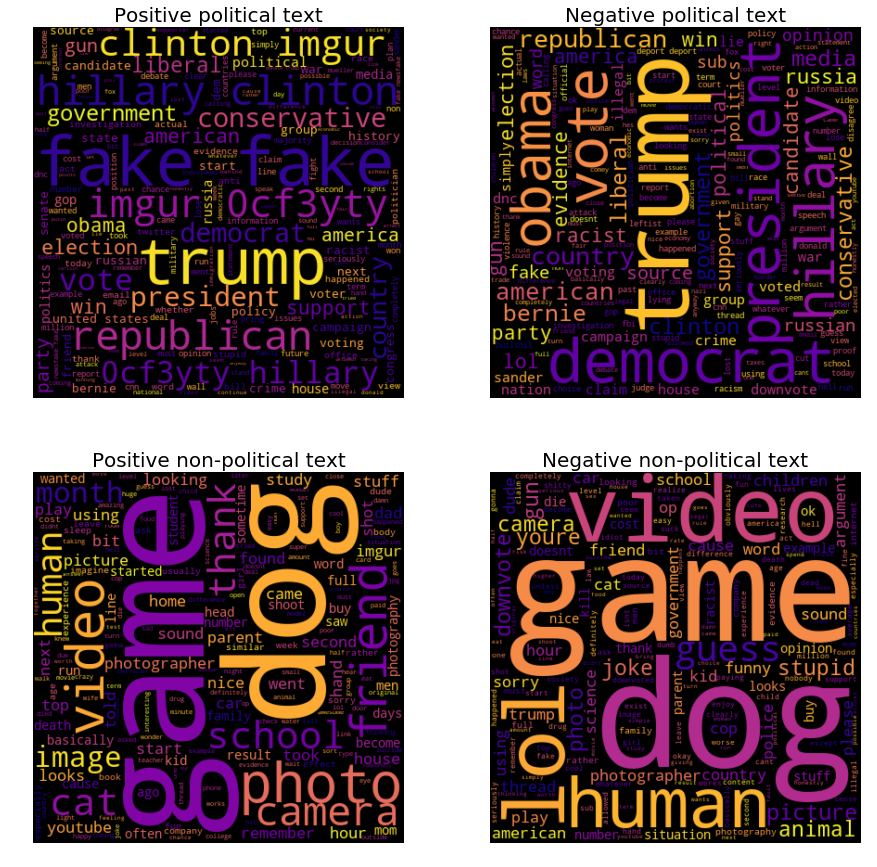

In [13]:
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    """Plot word cloud of given text"""
    # Generate a word cloud image
    wordcloud = (WordCloud(width=400, height=400,colormap='plasma')
                 .generate(text))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis("off");
    
# plot 2 x 2 grid of word clouds of each category of comment
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plot_wordcloud(wordstr_politics_hi2,'Positive political text')

plt.subplot(2,2,2)
plot_wordcloud(wordstr_politics_lo2,'Negative political text')

plt.subplot(2,2,3)
plot_wordcloud(wordstr_nonpolitics_hi2,'Positive non-political text')

plt.subplot(2,2,4)
plot_wordcloud(wordstr_nonpolitics_lo2,'Negative non-political text')


## Word clouds for words common to positive vs negative comments

Next, I want to combine all positive comments and all negative comments and look at the wordclouds for each. Are there words that predict positive or negative voting scores? 

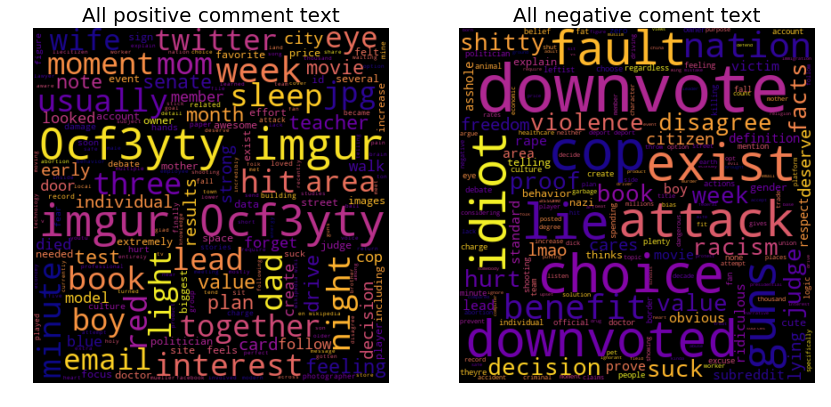

In [15]:
# number of common words to remove
wordcount = 1000

# create lists of positive and negative comment words
wordlist_hi = text_to_wordlist(wordstr_politics_hi + wordstr_nonpolitics_hi)
wordlist_lo = text_to_wordlist(wordstr_politics_lo + wordstr_nonpolitics_lo)

# get list of words common to positive and negative comments
common_to_all = ( 
    set(list_words_by_most_common(wordlist_hi)[:wordcount]) &
    set(list_words_by_most_common(wordlist_lo)[:wordcount]) 
    )

# re-assemble text for all positive and negative comments, 
#  subtracting common words
wordstr_hi = ' '.join([w for w in wordlist_hi if w not in common_to_all])
wordstr_lo = ' '.join([w for w in wordlist_lo if w not in common_to_all])

# plot word clouds of positive and negative comment texts
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plot_wordcloud(wordstr_hi,'All positive comment text')

plt.subplot(1,2,2)
plot_wordcloud(wordstr_lo,'All negative coment text')
